In [2]:
###### %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import *
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# utility function for showing images
def show_imgs(x_test, decoded_imgs, n=4):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(size,size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(size,size))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

### Create input

bs_z=16

train_path = "/home/hoffmann/MA/OIRDS_v1_0/train"
test_path = "/home/hoffmann/MA/OIRDS_v1_0/test"

size=256

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path,target_size=(size,size),color_mode='rgb',batch_size=bs_z, class_mode = 'input',shuffle=False)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,target_size=(size,size),color_mode='rgb',batch_size=bs_z, class_mode = 'input',shuffle=False)

/home/hoffmann/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 845 images belonging to 1 classes.
Found 37 images belonging to 1 classes.


In [3]:
### pretrain1
    
input_img = Input(shape=(size, size,1))

train1_norm=BatchNormalization(axis=-1, name='t1n')(input_img)
train1_c1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='t1c1')(train1_norm)
train1_decoded = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', name='t1tc1')(train1_c1)

train1_autoencoder = Model(input_img, train1_decoded)
train1_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train1_autoencoder.fit_generator(train_batches, epochs=10, validation_data=test_batches, verbose=1)

### pretrain2

creator_train2 = Model(input_img, train1_c1)
creator_train2.get_layer("t1c1").set_weights(train1_autoencoder.get_layer('t1c1').get_weights())

input_train2 = creator_train2.predict_generator(train_batches)

print(input_train2.shape)

#---

input_img_train2 = Input(shape=(size, size, 16))
train2_p1 = MaxPooling2D(pool_size=(2, 2), name='t2p1')(input_img_train2)
train2_c1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='t2c1')(train2_p1)
train2_tc1 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name='t2tc1')(train2_c1)
train2_decoded = UpSampling2D(size=(2, 2), name='t3u1')(train2_tc1)

train2_autoencoder = Model(input_img_train2, train2_decoded)
train2_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train2_autoencoder.fit(input_train2, input_train2, epochs=10, batch_size=bs_z, verbose=1)

### pretrain3

creator_train3 = Model(input_img_train2, train2_c1)
creator_train3.get_layer("t2c1").set_weights(train2_autoencoder.get_layer('t2c1').get_weights())

input_train3 = creator_train3.predict(input_train2)

print(input_train3.shape)

#---

input_img_train3 = Input(shape=(size/2, size/2, 8))
train3_p1 = MaxPooling2D(pool_size=(2, 2), name='t3p1')(input_img_train3)
train3_c1 = Conv2D(4, (3, 3), activation='relu', padding='same', name='t3c1')(train3_p1)
train3_tc1 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same', name='t3tc1')(train3_c1)
train3_decoded = UpSampling2D(size=(2, 2), name='t3u1')(train3_tc1)

train3_autoencoder = Model(input_img_train3, train3_decoded)
train3_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

train3_autoencoder.fit(input_train3, input_train3, epochs=10, batch_size=bs_z, verbose=1)


(845, 256, 256, 16)
(845, 256, 256, 16)


In [4]:
### unroll

input_img = Input(shape=(size, size,1))

norm=BatchNormalization(axis=-1, name='n', weights=train1_autoencoder.get_layer("t1n").get_weights())(input_img)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='c1', weights=train1_autoencoder.get_layer("t1c1").get_weights())(norm)
p1 = MaxPooling2D(pool_size=(2, 2), name='p1')(c1)
c2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='c2', weights=train2_autoencoder.get_layer("t2c1").get_weights())(p1)
p2 = MaxPooling2D(pool_size=(2, 2), name='p2')(c2)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same', name='c3', weights=train3_autoencoder.get_layer("t3c1").get_weights())(p2)
tc3 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same', name='tc3', weights=train3_autoencoder.get_layer("t3tc1").get_weights())(encoded)
u2 = UpSampling2D(size=(2, 2), name='u2')(tc3)
tc2 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same', name='tc2', weights=train2_autoencoder.get_layer("t2tc1").get_weights())(u2)
u1 = UpSampling2D(size=(2, 2), name='u1')(tc2)
decoded = Conv2DTranspose(1, (3, 3), activation='relu', padding='same', name='tc1', weights=train1_autoencoder.get_layer("t1tc1").get_weights())(u1)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

### finetune

autoencoder.fit_generator(train_batches, epochs=20, validation_data=test_batches, verbose=1)

In [5]:
autoencoder.save('CAE_overhead_20ep_2pool_4f.h5')

In [19]:
def getMaxGrads(input_set, model, layer_name, nof):
    
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    
    out = np.zeros((len(input_set),len(input_set[0]),len(input_set[0][0])))

    for i in range(nof):
        filter_index = i  # can be any integer from 0 to 511, as there are 512 filters in that layer

        layer_output = layer_dict[layer_name].output
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        #normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  ### normalize? ... later

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        it = iterate([input_set])
        
        len1=len(out)
        len2=len(out[0])
        len3=len(out[0][0])
        
        for j in range(len1):
            for k in range(len2):
                for l in range(len3):
                    if abs(it[1][j][k][l]) > out[j][k][l]:   #abs()?
                        out[j][k][l]=abs(it[1][j][k][l])
                        
        return out

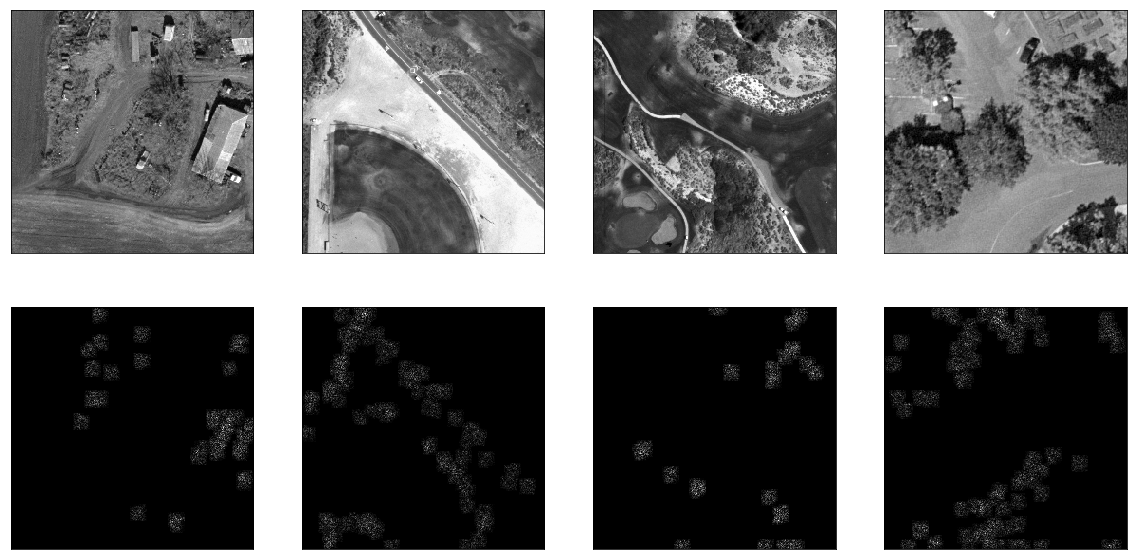

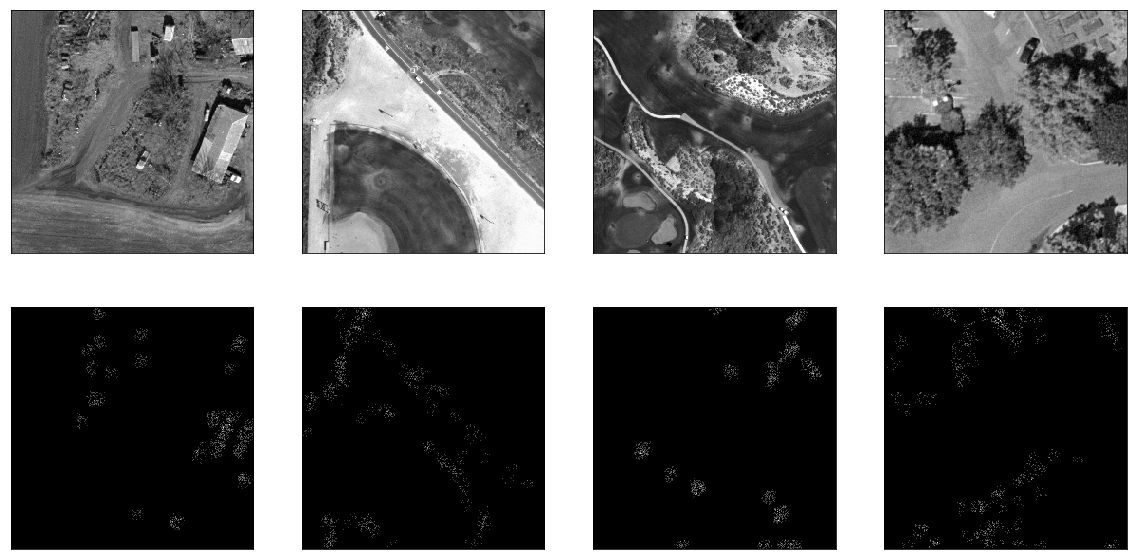

In [33]:
out = getMaxGrads(test_batches[0][0], autoencoder, 'c3', 4)

a=len(test_batches[0][0])
b=len(test_batches[0][0][0])
c=len(test_batches[0][0][0][0])

it_temp = np.zeros((a,b,c))

    for i in range(a):
        q = np.percentile(out[i],98)
        for j in range(b):
            for k in range(c):
                if(out[i][j][k]>q):
                    it_temp[i][j][k]=out[i][j][k]

In [37]:
writegrads = np.zeros((len(it_temp),len(it_temp[0])*len(it_temp[0])))

for i in range(len(it_temp)):
    temp = []
    for j in it_temp[i]:
        temp.extend(j)
    writegrads[i] = temp

np.savetxt('CAE_overhead_20ep_2pool_4f',writegrads)

In [ ]:
### plot

decoded_imgs = autoencoder.predict_generator(test_batches)
show_imgs(test_batches[0][0],decoded_imgs)

print(autoencoder.summary())

autoencoder_show_hidden = Model(input_img, encoded)
encoded_imgs = autoencoder_show_hidden.predict_generator(test_batches)

def show_hidden(x_test, encoded_imgs, n=10):
    
    en0=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en1=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en2=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en3=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))

    for i in range(encoded_imgs.shape[0]):
        for j in range(encoded_imgs.shape[1]):
            for k in range(encoded_imgs.shape[2]):
                en0[i][j][k]=encoded_imgs[i][j][k][0]
                en1[i][j][k]=encoded_imgs[i][j][k][1]
                en2[i][j][k]=encoded_imgs[i][j][k][2]
                en3[i][j][k]=encoded_imgs[i][j][k][3]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(5, n, i+1)
        plt.imshow(x_test[i].reshape(size,size))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(5, n, i+ 1 +n)
            plt.imshow(en0[i].reshape(int(size/4),int(size/4)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +2*n)
            plt.imshow(en1[i].reshape(int(size/4),int(size/4)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +3*n)
            plt.imshow(en2[i].reshape(int(size/4),int(size/4)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +4*n)
            plt.imshow(en3[i].reshape(int(size/4),int(size/4)))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

show_hidden(test_batches[0][0], encoded_imgs)

#print grads

show_imgs(test_batches[0][0],out)

show_imgs(test_batches[0][0],it_temp)
